1. category 대소문자 맞추기

2. author 띄어쓰기 해결

3. books 데이터셋 => 성현님 전처리 코드 긁어와서 그대로

4. users 데이터셋 => category에 'Juvenile'들어간 책 구매한 유저 10대로 처리. 어떻게? Junevile 최빈값 or 평균을 대체값으로 넣으면 될 듯

    (0)location과 age 모두 nan인 user 2명+age가 nan인 유저 중 대량으로 구매한 유저. 얘네는 nan값 자체를 age로 설정해야할 듯.(예외로 생각해야할 듯)

    (1)language: 범주별 boxplot 그려서 10살 범위보다 박스가 작은 것만 평균으로 대체하기

    (2)category: fiction이 관건임. 나머지는 100개 이상인 category들만 똑같이 boxplot 그려서 같은 방법으로. 100개 이하는 그냥 nan값으로 나둬도 괜찮을 듯. fiction은 일단 보류

    (3)country: 어카누

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import requests
import matplotlib.pyplot as plt
from PIL import Image

import re

In [296]:
users = pd.read_csv('/opt/ml/data/users_origin.csv')
books = pd.read_csv('/opt/ml/data/books.csv')
ratings = pd.read_csv('/opt/ml/data/train_ratings.csv')

In [297]:
print("users shape: ",users.shape)
print("books shape: ",books.shape)
print("ratings shape: ",ratings.shape)

users shape:  (68092, 3)
books shape:  (149570, 11)
ratings shape:  (306795, 3)


In [317]:
user_rating = pd.merge(users,ratings, on='user_id')

In [328]:
all_merge = pd.merge(user_rating,books,on='isbn')
all_merge

,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
0,8,"timmins, ontario, canada",NaN,0002005018,4,Clara Callan,richard bruce wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
1,67544,"toronto, ontario, canada",30.0,0002005018,7,Clara Callan,richard bruce wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
2,123629,"kingston, ontario, canada",NaN,0002005018,8,Clara Callan,richard bruce wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
3,200273,"comber, ontario, canada",NaN,0002005018,8,Clara Callan,richard bruce wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
4,210926,"guelph, ontario, canada",NaN,0002005018,9,Clara Callan,richard bruce wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306790,278376,"danville, pennsylvania, usa",54.0,0060530103,7,The Grandmothers : Four Short Novels,doris lessing,2004.0,HarperCollins,http://images.amazon.com/images/P/0060530103.0...,en,['africa'],NaN,images/0060530103.01.THUMBZZZ.jpg
306791,278621,"victoria, delaware, canada",74.0,1550390961,8,"Gilean Douglas: Writing Nature, Finding Home",andrea pinto lebowitz,1999.0,Sono Nis Press,http://images.amazon.com/images/P/1550390961.0...,en,"['authors, canadian (english) 20th century bio...",Her writings span almost the entire twentieth ...,images/1550390961.01.THUMBZZZ.jpg
306792,278636,"irvington, alabama, usa",NaN,0375507299,2,The Snow Geese: A Story of Home,william fiennes,2002.0,Random House,http://images.amazon.com/images/P/0375507299.0...,en,NaN,NaN,images/0375507299.01.THUMBZZZ.jpg
306793,278659,"vancouver, washington, usa",33.0,0345330293,10,Town Like Alice,nevil shute,1981.0,Ballantine Books,http://images.amazon.com/images/P/0345330293.0...,en,['fiction'],NaN,images/0345330293.01.THUMBZZZ.jpg


In [329]:
all_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306795 entries, 0 to 306794
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   user_id              306795 non-null  int64  
 1   location             306795 non-null  object 
 2   age                  252532 non-null  float64
 3   isbn                 306795 non-null  object 
 4   rating               306795 non-null  int64  
 5   book_title           306795 non-null  object 
 6   book_author          306795 non-null  object 
 7   year_of_publication  306795 non-null  float64
 8   publisher            306795 non-null  object 
 9   img_url              306795 non-null  object 
 10  language             306795 non-null  object 
 11  category             277834 non-null  object 
 12  summary              187711 non-null  object 
 13  img_path             306795 non-null  object 
dtypes: float64(2), int64(2), object(10)
memory usage: 35.1+ MB


# 1. category 대소문자

###### 성현님 방법 (publisher 별 가장 많은 category로 nan값 채우기)

In [124]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149570 entries, 0 to 149569
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 149570 non-null  object 
 1   book_title           149570 non-null  object 
 2   book_author          149570 non-null  object 
 3   year_of_publication  149570 non-null  float64
 4   publisher            149570 non-null  object 
 5   img_url              149570 non-null  object 
 6   language             82343 non-null   object 
 7   category             80719 non-null   object 
 8   summary              82343 non-null   object 
 9   img_path             149570 non-null  object 
dtypes: float64(1), object(9)
memory usage: 11.4+ MB


In [125]:
books['book_author'].nunique()

62059

In [126]:
books3 = books[['book_author','category']]
books3

,book_author,category
0,Richard Bruce Wright,['actresses']
1,Carlo D'Este,['1940-1949']
2,Gina Bari Kolata,['medical']
3,Amy Tan,['fiction']
4,Robert Cowley,['history']
...,...,...
149565,P.J. O'Rourke,['humor']
149566,Sam Lightner,['nature']
149567,Claude Dooley,NaN
149568,Jeremy Lloyd,['fiction']


In [127]:
book_author_category_count = books3.groupby(['book_author','category']).size().reset_index(name='count')
book_author_category_count

,book_author,category,count
0,D. Chiel,['fiction'],1
1,A A Milne,"[""children's stories""]",2
2,A A Milne,['bears'],2
3,A Blue Mountain Arts Collection,['literary criticism'],1
4,A Bodenburg Sommer,['performing arts'],1
...,...,...,...
49787,stephen R Donaldson,"['covenant, thomas (fictitious character)']",1
49788,tk,['juvenile fiction'],1
49789,translated by Rumer Godden,['religion'],1
49790,various authors,['christian life'],1


In [128]:
# 두 개 이상의 category 글을 쓴 저자 중 max count가 2개 이상 같은 경우. 
# 아래 방식대로라면 같은 count 중 그냥 가장 앞 category의 index가 채택됨.
#book_author_category_count[sum(book_author_category_count['book_author'])>=2]
# dup_author = book_author_category_count[book_author_category_count.duplicated(['book_author'],keep=False)]
# dup_author

In [129]:
# 저자별로 가장 많은 카테고리 찾기
max_category_by_author = book_author_category_count.loc[book_author_category_count.groupby('book_author')['count'].idxmax()]

# books 데이터프레임의 category 결측치 행 찾기
missing_category_rows = books[books['category'].isna()]

# 결측치를 채우기 위한 함수 정의
def fill_missing_category(row):
    author = row['book_author']
    if author in max_category_by_author['book_author'].values:
        return max_category_by_author.loc[max_category_by_author['book_author'] == author, 'category'].iloc[0]
    else:
        return np.nan

# 결측치를 채우기 위해 apply 함수 사용
books.loc[books['category'].isna(), 'category'] = missing_category_rows.apply(fill_missing_category, axis=1)

In [130]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149570 entries, 0 to 149569
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 149570 non-null  object 
 1   book_title           149570 non-null  object 
 2   book_author          149570 non-null  object 
 3   year_of_publication  149570 non-null  float64
 4   publisher            149570 non-null  object 
 5   img_url              149570 non-null  object 
 6   language             82343 non-null   object 
 7   category             122367 non-null  object 
 8   summary              82343 non-null   object 
 9   img_path             149570 non-null  object 
dtypes: float64(1), object(9)
memory usage: 11.4+ MB


###### 대소문자 통일

In [ ]:
np.set_printoptions(threshold=np.inf, linewidth=np.inf)
books[books['category'].str.contains("FICTION",na=False)]['category'].unique()

array(["['FICTION']", "['JUVENILE FICTION']", "['JUVENILE NONFICTION']"], dtype=object)

In [ ]:
books[books['category'].str.contains("FICTION",na=False)]

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
48,0842342702,Left Behind: A Novel of the Earth's Last Days ...,Tim Lahaye,2000.0,Tyndale House Publishers,http://images.amazon.com/images/P/0842342702.0...,en,['FICTION'],The first book in the author&#39;s successful ...,images/0842342702.01.THUMBZZZ.jpg
160,0385337639,Crow Lake (Today Show Book Club #7),Mary Lawson,2003.0,Delta,http://images.amazon.com/images/P/0385337639.0...,en,['FICTION'],"Kate Morrison, orphaned at the age of seven, g...",images/0385337639.01.THUMBZZZ.jpg
324,0345350499,The Mists of Avalon,MARION ZIMMER BRADLEY,1987.0,Del Rey,http://images.amazon.com/images/P/0345350499.0...,en,['FICTION'],Retells the legend of Arthur as perceived by V...,images/0345350499.01.THUMBZZZ.jpg
1297,014036336X,The House With a Clock in Its Walls,John Bellairs,1993.0,Puffin Books,http://images.amazon.com/images/P/014036336X.0...,en,['JUVENILE FICTION'],This classic is now reissued with a brand-new ...,images/014036336X.01.THUMBZZZ.jpg
1913,0684856603,All Through The Night : A Suspense Story,Mary Higgins Clark,1998.0,Simon & Schuster,http://images.amazon.com/images/P/0684856603.0...,en,['FICTION'],The best-selling author of You Belong to Me an...,images/0684856603.01.THUMBZZZ.jpg
...,...,...,...,...,...,...,...,...,...,...
118729,0553253220,The Californios,LOUIS L'AMOUR,1985.0,Bantam,http://images.amazon.com/images/P/0553253220.0...,en,['FICTION'],Just before gold was discovered in California ...,images/0553253220.01.THUMBZZZ.jpg
122617,0553280856,Chancy,LOUIS L'AMOUR,1984.0,Bantam,http://images.amazon.com/images/P/0553280856.0...,en,['FICTION'],After he guns down a cattle thief posing as a ...,images/0553280856.01.THUMBZZZ.jpg
123823,0763611484,Worm Is Stuck (Brand New Readers Series),Kathy Caple,2000.0,Candlewick Pr,http://images.amazon.com/images/P/0763611484.0...,en,['JUVENILE FICTION'],It&#39;s about all the shapes Worm turns himse...,images/0763611484.01.THUMBZZZ.jpg
125149,0140361235,When We Were Very Young,A. A. Milne,1992.0,Puffin Books,http://images.amazon.com/images/P/0140361235.0...,en,['JUVENILE FICTION'],A collection of poems reflecting the experienc...,images/0140361235.01.THUMBZZZ.jpg


In [ ]:
#convert all strings to lowercase
books['category'].str.lower()

0         ['actresses']
1         ['1940-1949']
2           ['medical']
3           ['fiction']
4           ['history']
              ...      
149565        ['humor']
149566       ['nature']
149567              NaN
149568      ['fiction']
149569              NaN
Name: category, Length: 149570, dtype: object

In [ ]:
print("before: ",books['category'].nunique())
print("after: ",books['category'].str.lower().nunique())

before:  4292
after:  4260


In [ ]:
books['category'] = books['category'].str.lower()

In [ ]:
books['category']

0         ['actresses']
1         ['1940-1949']
2           ['medical']
3           ['fiction']
4           ['history']
              ...      
149565        ['humor']
149566       ['nature']
149567              NaN
149568      ['fiction']
149569              NaN
Name: category, Length: 149570, dtype: object

# 2. author

In [132]:
#pd.set_option('display.max_columns',None)
books['book_author'].sort_values()

7271                              D. Chiel
68645                          Mimma Balia
109816    142 moms from all over the world
83420                  73 Magazine Editors
130812                     ;Katie Stewart"
                        ...               
139657                      Â¢ystein LÂ²nn
83635                  Ã?dÃ¶n von HorvÃ¡th
91117                  Ã?dÃ¶n von HorvÃ¡th
79938               Ã?Â?dÃ?Â¶n von Horvath
106992                      Ã?Â?pictÃ?Â¨te
Name: book_author, Length: 149570, dtype: object

In [133]:
books['book_author'].unique()

array(['Richard Bruce Wright', "Carlo D'Este", 'Gina Bari Kolata', 'Amy Tan', 'Robert Cowley', 'Scott Turow', 'Ann Beattie', 'David Adams Richards', 'Sheila Heti', 'R. J. Kaiser', 'Jack Canfield', 'Loren D. Estleman', 'Robert Hendrickson', 'Julia Oliver', 'John Grisham', 'Toni Morrison', 'The Onion', 'Celia Brooks Brown', 'J. R. Parrish', 'Mary-Kate & Ashley Olsen', 'Robynn Clairday', 'Kathleen Duey', 'Rich Shapero', 'Michael Crichton', 'MICHAEL CRICHTON', 'Rosamunde Pilcher', 'Agatha Christie', "Louis L'Amour", 'ISAAC ASIMOV', 'C.S. Lewis', 'Frank E. Peretti', 'ARTHUR PHILLIPS', 'Stephan Jaramillo', 'Mordecai Richler', 'Mark Salzman', 'Harper Lee', 'LAURA HILLENBRAND', 'Barbara Kingsolver', 'Jo Dereske', 'Dolores Krieger', 'Anne Rivers Siddons', 'Dean R. Koontz', 'Mary Higgins Clark', 'Dean Koontz', 'Patricia Cornwell', 'J.D. Robb', 'Maeve Binchy', 'Tim Lahaye', 'JOHN GRISHAM', 'M.D. Bernie S. Siegel', 'Robert Penn Warren', 'Hans Johannes Hoefer', 'Mark Helprin', 'David Iglehart', 'La

In [134]:
sorted(books['book_author'].unique())

[' D. Chiel',
 ' Mimma Balia',
 '142 moms from all over the world',
 '73 Magazine Editors',
 ';Katie Stewart"',
 'A & C Black Ltd.',
 'A A Milne',
 'A Blue Mountain Arts Collection',
 'A Bodenburg Sommer',
 'A E Hartink',
 'A Lobo Antunes',
 'A Martin',
 'A Monk of the Eastern Church',
 'A Norman Jeffares',
 'A Perry',
 'A Rich',
 'A S Byatt',
 "A'Lelia Bundles",
 'A. A Milne',
 'A. A. Attanasio',
 'A. A. Carr',
 'A. A. Gill',
 'A. A. Hoehling',
 'A. A. Milne',
 'A. A. Winnie the Pooh Milne',
 'A. Alli',
 'A. Alvarez',
 'A. Anatoli',
 'A. B. C. Whipple',
 'A. B. Guthrie',
 'A. B. Yehoshua',
 'A. Balfour',
 'A. Barrie',
 'A. Bartlett Giamatti',
 'A. Bates',
 'A. Bertrand',
 'A. Breton',
 'A. Brill',
 'A. Bruce Carlson',
 'A. Bry',
 'A. Buero Vallejo',
 'A. C. (Alan C.) Weisbecker',
 'A. C. Bhaktivedanta Swami Prabhupada',
 'A. C. Bhaktivedanta Swami Prabhupada et al.',
 'A. C. Cawley',
 'A. C. Crispin',
 'A. C. Doyle',
 'A. C. Fox-Davies',
 'A. C. Gordon',
 'A. C. H. Smith',
 'A. C. Par

In [135]:
# the fuzz 기반 hnmi(얘는 오차 많을 듯. 겹치는 비율 이용해서)

#delete comma(,) 
#convert '-' to ' '
#convert all strings to losercase ('AARON ALLSTON' == 'Aaron Allston')
#first/last charcter (;Katie Stewart" == "Katie Stewart")
#'A. W Reed' == 'A.W. Reed', 'Aa.Vv' , Abraham. Chill'(<-should delete .)==> . 어떻게 처리할건지(문자 or 특수문자)
#'Abraham H.  Maslow' ==> 띄어쓰기 중간에 2번

In [136]:
books[books['book_author']=='Katie Stewart']

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
39015,0600353214,The Times calendar cookbook,Katie Stewart,1975.0,Hamlyn [for] Times Books,http://images.amazon.com/images/P/0600353214.0...,NaN,NaN,NaN,images/0600353214.01.THUMBZZZ.jpg


## 1. delete comma(,)

In [137]:
books['book_author']

0         Richard Bruce Wright
1                 Carlo D'Este
2             Gina Bari Kolata
3                      Amy Tan
4                Robert Cowley
                  ...         
149565           P.J. O'Rourke
149566            Sam Lightner
149567           Claude Dooley
149568            Jeremy Lloyd
149569                  Mapsco
Name: book_author, Length: 149570, dtype: object

In [138]:
books[books['book_author'].str.contains(',',case=False)]['book_author']
#Scott, Cunningham == Scott Cunningham

587                  Scott, Cunningham
712                 Mark E., Jr. Neely
1217             Rush H., III Limbaugh
3196             Debra K., Dr. Shatoff
3507               Anthony, Md. Walker
                      ...             
148443    Richard G., M.S.W. Whiteside
148872         Frederick David, Graves
149405          Dena, Ph.D. Rosenbloom
149429           Lonnie, Ph.D. Barbach
149530              Jeffrey, A. Carver
Name: book_author, Length: 729, dtype: object

In [139]:
print("before: ", books['book_author'].nunique())
print("after: ",books['book_author'].str.replace(r'[,]','').nunique())

before:  62059
after:  62004


/tmp/ipykernel_44097/987767951.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  print("after: ",books['book_author'].str.replace(r'[,]','').nunique())


In [140]:
books['book_author'] = books['book_author'].str.replace(',','')

In [141]:
books['book_author'].nunique()

62004

## 2 convert '-' to ' '

In [142]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149570 entries, 0 to 149569
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 149570 non-null  object 
 1   book_title           149570 non-null  object 
 2   book_author          149570 non-null  object 
 3   year_of_publication  149570 non-null  float64
 4   publisher            149570 non-null  object 
 5   img_url              149570 non-null  object 
 6   language             82343 non-null   object 
 7   category             122367 non-null  object 
 8   summary              82343 non-null   object 
 9   img_path             149570 non-null  object 
dtypes: float64(1), object(9)
memory usage: 11.4+ MB


In [143]:
books[books['book_author'].str.contains('-')]

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
19,0061076031,Mary-Kate & Ashley Switching Goals (Mary-Kate ...,Mary-Kate & Ashley Olsen,2000.0,HarperEntertainment,http://images.amazon.com/images/P/0061076031.0...,en,['juvenile fiction'],Problems arise when identical twins Emma and S...,images/0061076031.01.THUMBZZZ.jpg
138,2070567842,Folio Junior: L'histoire De Monsieur Sommer,Su>skind-Sempe,1994.0,Gallimard-Jeunesse,http://images.amazon.com/images/P/2070567842.0...,fr,NaN,Un petit garçon se pose énormément de question...,images/2070567842.01.THUMBZZZ.jpg
536,8483007010,El gust amarg de la cervesa (CollecciÃ³ ClÃ ss...,Isabel-Clara SimÃ³,1999.0,Columna,http://images.amazon.com/images/P/8483007010.0...,ca,['fiction'],"Des de la finestra de casa seva, en Ramon -un ...",images/8483007010.01.THUMBZZZ.jpg
583,0156528207,The Little Prince,Antoine de Saint-ExupÃ©ry,1968.0,Harcourt,http://images.amazon.com/images/P/0156528207.0...,en,['juvenile fiction'],A pilot is forced down in the Sahara where he ...,images/0156528207.01.THUMBZZZ.jpg
627,8478800336,CÃ³mo ser una mujer y no morir en el intento (...,Carmen Rico-Godoy,1990.0,Ediciones Temas de Hoy,http://images.amazon.com/images/P/8478800336.0...,es,['women'],"Si eres mujer, esposa, madre o hija, no dejes ...",images/8478800336.01.THUMBZZZ.jpg
...,...,...,...,...,...,...,...,...,...,...
148901,3525335423,Das Deutsche Kaiserreich 1871-1918.,Hans-Ulrich Wehler,1994.0,Vandenhoeck & Ruprecht,http://images.amazon.com/images/P/3525335423.0...,NaN,NaN,NaN,images/3525335423.01.THUMBZZZ.jpg
148974,0805057021,An American Killing,Mary-Ann Tirone Smith,1998.0,Henry Holt & Company,http://images.amazon.com/images/P/0805057021.0...,en,['fiction'],Serious enough to make her Numero Uno for the ...,images/0805057021.01.THUMBZZZ.jpg
149172,1552093654,"You Eat What You Are: People, Culture and Food...",Thelma Barer-Stein,1999.0,Firefly Books Ltd,http://images.amazon.com/images/P/1552093654.0...,en,['cooking'],Exploration of more than 100 culinary traditio...,images/1552093654.01.THUMBZZZ.jpg
149418,2723426890,"Nomad, tome 5 : MÃ?Â©moire cachÃ?Â©e",Jean-David Morvan,2000.0,GlÃ?Â©nat,http://images.amazon.com/images/P/2723426890.0...,NaN,NaN,NaN,images/2723426890.01.THUMBZZZ.jpg


In [144]:
print("before: ", books['book_author'].nunique())
print("after: ",books['book_author'].str.replace(r'[-]',' ').nunique())

before:  62004
after:  61944


/tmp/ipykernel_44097/3655646768.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  print("after: ",books['book_author'].str.replace(r'[-]',' ').nunique())


In [145]:
books['book_author'] = books['book_author'].str.replace(r'[-]',' ')

/tmp/ipykernel_44097/540202652.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  books['book_author'] = books['book_author'].str.replace(r'[-]',' ')


## 3.convert all strings to losercase ('AARON ALLSTON' == 'Aaron Allston')

In [146]:
print("before: ",books['book_author'].nunique())
print("after: ", books['book_author'].str.lower().nunique())

before:  61944
after:  60172


In [147]:
books['book_author'] = books['book_author'].str.lower()
#books[books['book_author'].str.contains('aaron allston',case=False)]

## 4.first/last charcter (;Katie Stewart" == "Katie Stewart")


위에 Katie만 처리하고 나머지 그대로

In [148]:
test = "why why why"
re.sub(r'[w-z]','',test)

'h h h'

In [149]:
books[books['book_author'].str.startswith(';')]
#str.startwith은 정규식을 못 알아먹는다...

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
130812,0416652700,The Pooh cook book: inspired by \Winnie-the-Po...,";katie stewart""",1971.0,Methuen,http://images.amazon.com/images/P/0416652700.0...,NaN,NaN,NaN,images/0416652700.01.THUMBZZZ.jpg


In [150]:
sorted(books['book_author'])

[' d. chiel',
 ' mimma balia',
 '142 moms from all over the world',
 '73 magazine editors',
 ';katie stewart"',
 '\\\\"ron\\""',
 '\\abu\\""',
 '\\beshlie\\""',
 '\\family circle\\""',
 '\\good housekeeping\\""',
 '\\goscinny\\""',
 '\\lulu\\""',
 '\\pickles\\""',
 '\\septima\\""',
 '\\time out\\""',
 'a & c black ltd.',
 'a a milne',
 'a a milne',
 'a a milne',
 'a a milne',
 'a a milne',
 'a blue mountain arts collection',
 'a bodenburg sommer',
 'a e hartink',
 'a e hartink',
 'a lobo antunes',
 'a martin',
 'a martin',
 'a martin',
 'a monk of the eastern church',
 'a norman jeffares',
 'a perry',
 'a rich',
 'a rich',
 'a s byatt',
 "a'lelia bundles",
 'a. a milne',
 'a. a. attanasio',
 'a. a. attanasio',
 'a. a. attanasio',
 'a. a. attanasio',
 'a. a. carr',
 'a. a. gill',
 'a. a. hoehling',
 'a. a. milne',
 'a. a. milne',
 'a. a. milne',
 'a. a. milne',
 'a. a. milne',
 'a. a. milne',
 'a. a. milne',
 'a. a. milne',
 'a. a. milne',
 'a. a. milne',
 'a. a. milne',
 'a. a. milne',

In [151]:
books[books['book_author'].str.contains('/')]

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
28897,1555611435,Your Pregnancy: Week by Week (Your Pregnancy S...,glade b. curtis m.d. ob/gyn,1997.0,Perseus Books Group,http://images.amazon.com/images/P/1555611435.0...,en,['health & fitness'],A week-by-week guide that provides information...,images/1555611435.01.THUMBZZZ.jpg
36295,0075536501,Medieval Romances,roger sherman loomis/loomis,1965.0,McGraw-Hill Humanities/Social Sciences/Languages,http://images.amazon.com/images/P/0075536501.0...,NaN,NaN,NaN,images/0075536501.01.THUMBZZZ.jpg
99619,2877302830,Mort et vie de mishima,scott stokes/henry,1997.0,Philippe Picquier,http://images.amazon.com/images/P/2877302830.0...,NaN,NaN,NaN,images/2877302830.01.THUMBZZZ.jpg
111281,2841981029,L'AromathÃ?Â©rapie: Des mÃ?Â©thodes simples po...,evans/holmes,1998.0,Manise,http://images.amazon.com/images/P/2841981029.0...,NaN,NaN,NaN,images/2841981029.01.THUMBZZZ.jpg
120275,B00013AX9E,Modern Contemporary: Aspects of Art at MoMA Si...,p ed varnedoe/antonelli kick,2000.0,Museum of Modern Arts,http://images.amazon.com/images/P/B00013AX9E.0...,NaN,NaN,NaN,images/B00013AX9E.01.THUMBZZZ.jpg
121889,0786833904,Disney's Pop-Up Princesses,t/k,2002.0,Disney Press,http://images.amazon.com/images/P/0786833904.0...,en,['juvenile fiction'],"Dance with Snow White and the Seven Dwarfs, gl...",images/0786833904.01.THUMBZZZ.jpg
123621,0786833416,Book of Pooh: Picture Poems (Book of Pooh),t/k,2001.0,Disney Press,http://images.amazon.com/images/P/0786833416.0...,en,['juvenile fiction'],"Rebus books, in which pictures substitute for ...",images/0786833416.01.THUMBZZZ.jpg


In [152]:
books[books['book_author']=='\\lulu\\""']

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
138898,0751533718,Lulu,"\lulu\""""",2003.0,Time Warner Paperbacks,http://images.amazon.com/images/P/0751533718.0...,NaN,NaN,NaN,images/0751533718.01.THUMBZZZ.jpg


In [153]:
books[books['book_author'].str.endswith('"')]['book_author']

18350        evelyn \slim\" lambright"
27981                    miss\ \"read"
29348                      \pickles\""
35144               david \zeb\" cook"
39243            \good housekeeping\""
47804         ginger \sugar\" blymyer"
47805       jo ann gallodoro \poopa\""
52064        eugene \mercury\" morris"
70507                      \septima\""
77951     matthew \dr. matt\" abergel"
87754                        j\ \"j\""
92752           jim \catfish\" hunter"
97963               david \zeb\" cook"
100116                    \goscinny\""
104519            del \irish\" meader"
105450                         \abu\""
107342                    \time out\""
108014    john \the penguin\" bingham"
108295              e.e. \doc\" smith"
119430                     \beshlie\""
120807        earvin \magic\" johnson"
121738          kim \howard\" johnson"
130658                       \\"ron\""
130812                 ;katie stewart"
138898                        \lulu\""
140720               \fam

In [154]:
#그냥 Katie 빼고 그대로
books['book_author'][books['book_author'].str.startswith(';')] = 'katie stewart'
#= 'katie stewart'

/tmp/ipykernel_44097/1080910012.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books['book_author'][books['book_author'].str.startswith(';')] = 'katie stewart'


In [155]:
books[books['book_author'].str.startswith(';')]

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path


In [156]:
sorted(books['book_author'].unique())

[' d. chiel',
 ' mimma balia',
 '142 moms from all over the world',
 '73 magazine editors',
 '\\\\"ron\\""',
 '\\abu\\""',
 '\\beshlie\\""',
 '\\family circle\\""',
 '\\good housekeeping\\""',
 '\\goscinny\\""',
 '\\lulu\\""',
 '\\pickles\\""',
 '\\septima\\""',
 '\\time out\\""',
 'a & c black ltd.',
 'a a milne',
 'a blue mountain arts collection',
 'a bodenburg sommer',
 'a e hartink',
 'a lobo antunes',
 'a martin',
 'a monk of the eastern church',
 'a norman jeffares',
 'a perry',
 'a rich',
 'a s byatt',
 "a'lelia bundles",
 'a. a milne',
 'a. a. attanasio',
 'a. a. carr',
 'a. a. gill',
 'a. a. hoehling',
 'a. a. milne',
 'a. a. winnie the pooh milne',
 'a. alli',
 'a. alvarez',
 'a. anatoli',
 'a. b. c. whipple',
 'a. b. guthrie',
 'a. b. yehoshua',
 'a. balfour',
 'a. barrie',
 'a. bartlett giamatti',
 'a. bates',
 'a. bertrand',
 'a. breton',
 'a. brill',
 'a. bruce carlson',
 'a. bry',
 'a. buero vallejo',
 'a. c. (alan c.) weisbecker',
 'a. c. bhaktivedanta swami prabhupada

In [157]:
books['book_author'].nunique()

60171

## 5. '.' 어떻게 처리할건지(문자 or 특수문자)

A. W Reed' == 'A.W. Reed', 'Aa.Vv' , Abraham. Chill'(<-should delete .)

In [158]:
#delete all + also ";"
a = books['book_author'].str.replace(".","")
sorted(a.unique())
a.nunique()
#엥 잘 된건지 확인이 안 됨

/tmp/ipykernel_44097/2324002417.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  a = books['book_author'].str.replace(".","")


59765

In [159]:
sorted(books['book_author'].unique())

[' d. chiel',
 ' mimma balia',
 '142 moms from all over the world',
 '73 magazine editors',
 '\\\\"ron\\""',
 '\\abu\\""',
 '\\beshlie\\""',
 '\\family circle\\""',
 '\\good housekeeping\\""',
 '\\goscinny\\""',
 '\\lulu\\""',
 '\\pickles\\""',
 '\\septima\\""',
 '\\time out\\""',
 'a & c black ltd.',
 'a a milne',
 'a blue mountain arts collection',
 'a bodenburg sommer',
 'a e hartink',
 'a lobo antunes',
 'a martin',
 'a monk of the eastern church',
 'a norman jeffares',
 'a perry',
 'a rich',
 'a s byatt',
 "a'lelia bundles",
 'a. a milne',
 'a. a. attanasio',
 'a. a. carr',
 'a. a. gill',
 'a. a. hoehling',
 'a. a. milne',
 'a. a. winnie the pooh milne',
 'a. alli',
 'a. alvarez',
 'a. anatoli',
 'a. b. c. whipple',
 'a. b. guthrie',
 'a. b. yehoshua',
 'a. balfour',
 'a. barrie',
 'a. bartlett giamatti',
 'a. bates',
 'a. bertrand',
 'a. breton',
 'a. brill',
 'a. bruce carlson',
 'a. bry',
 'a. buero vallejo',
 'a. c. (alan c.) weisbecker',
 'a. c. bhaktivedanta swami prabhupada

In [160]:
a[a =='aw reed']

125934    aw reed
Name: book_author, dtype: object

In [161]:
books['book_author'] = a

In [162]:
books

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
0,0002005018,Clara Callan,richard bruce wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
1,0060973129,Decision in Normandy,carlo d'este,1991.0,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,en,['1940-1949'],"Here, for the first time in paperback, is an o...",images/0060973129.01.THUMBZZZ.jpg
2,0374157065,Flu: The Story of the Great Influenza Pandemic...,gina bari kolata,1999.0,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,en,['medical'],"Describes the great flu epidemic of 1918, an o...",images/0374157065.01.THUMBZZZ.jpg
3,0399135782,The Kitchen God's Wife,amy tan,1991.0,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,en,['fiction'],A Chinese immigrant who is convinced she is dy...,images/0399135782.01.THUMBZZZ.jpg
4,0425176428,What If?: The World's Foremost Military Histor...,robert cowley,2000.0,Berkley Publishing Group,http://images.amazon.com/images/P/0425176428.0...,en,['history'],"Essays by respected military historians, inclu...",images/0425176428.01.THUMBZZZ.jpg
...,...,...,...,...,...,...,...,...,...,...
149565,067161746X,The Bachelor Home Companion: A Practical Guide...,pj o'rourke,1987.0,Pocket Books,http://images.amazon.com/images/P/067161746X.0...,en,['humor'],A tongue-in-cheek survival guide for single pe...,images/067161746X.01.THUMBZZZ.jpg
149566,0767907566,All Elevations Unknown: An Adventure in the He...,sam lightner,2001.0,Broadway Books,http://images.amazon.com/images/P/0767907566.0...,en,['nature'],A daring twist on the travel-adventure genre t...,images/0767907566.01.THUMBZZZ.jpg
149567,0884159221,Why stop?: A guide to Texas historical roadsid...,claude dooley,1985.0,Lone Star Books,http://images.amazon.com/images/P/0884159221.0...,NaN,NaN,NaN,images/0884159221.01.THUMBZZZ.jpg
149568,0912333022,The Are You Being Served? Stories: 'Camping In...,jeremy lloyd,1997.0,Kqed Books,http://images.amazon.com/images/P/0912333022.0...,en,['fiction'],These hilarious stories by the creator of publ...,images/0912333022.01.THUMBZZZ.jpg


In [165]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149570 entries, 0 to 149569
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 149570 non-null  object 
 1   book_title           149570 non-null  object 
 2   book_author          149570 non-null  object 
 3   year_of_publication  149570 non-null  float64
 4   publisher            149570 non-null  object 
 5   img_url              149570 non-null  object 
 6   language             82343 non-null   object 
 7   category             122367 non-null  object 
 8   summary              82343 non-null   object 
 9   img_path             149570 non-null  object 
dtypes: float64(1), object(9)
memory usage: 11.4+ MB


# 3. language

1. language는 publisher와 더 연관있다.

2. language는 author와 더 연관있다.

판단기준: publisher별 or author별로 language 종류가 적을수록 연관있을 것?

==> 그냥 성현님 방식대로.(publisher 별로 가장 많은 language)

In [166]:
category_high_df = pd.DataFrame(books['language'].value_counts()).reset_index()
category_high_df.columns = ['language','count']
category_high_df.head(10)

,language,count
0,en,78823
1,de,1282
2,es,1017
3,fr,883
4,it,123
5,nl,67
6,pt,47
7,da,37
8,ca,23
9,ms,10


In [170]:
books2 = books[['publisher', 'language']]
    # publisher와 language 별로 그룹화하여 카운트 계산
publisher_language_count = books2.groupby(['publisher', 'language']).size().reset_index(name='count')

    # publisher별로 가장 많은 언어 찾기
max_language_by_publisher = publisher_language_count.loc[publisher_language_count.groupby('publisher')['count'].idxmax()]
max_language_by_publisher

,publisher,language,count
1,10-18,fr,10
2,10/18,fr,4
3,1001 nuits,fr,1
4,11/9 Publishing,en,1
5,1stBooks Library,en,41
...,...,...,...
6654,"sole distributors for the U.S.A. and Canada, E...",en,1
6655,toExcel,en,1
6656,trade distribution by Simon and Schuster,en,1
6657,Ã?ditions Michalon,fr,1


In [171]:
# books 데이터프레임의 language 결측치 행 찾기
missing_language_rows = books[books['language'].isna()]

# 결측치를 채우기 위한 함수 정의
def fill_missing_language(row):
    publisher = row['publisher']
    if publisher in max_language_by_publisher['publisher'].values:
        return max_language_by_publisher.loc[max_language_by_publisher['publisher'] == publisher, 'language'].iloc[0]
    else:
        return 'en'

# 결측치를 채우기 위해 apply 함수 사용
books.loc[books['language'].isna(), 'language'] = missing_language_rows.apply(fill_missing_language, axis=1)

In [290]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149570 entries, 0 to 149569
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 149570 non-null  object 
 1   book_title           149570 non-null  object 
 2   book_author          149570 non-null  object 
 3   year_of_publication  149570 non-null  float64
 4   publisher            149570 non-null  object 
 5   img_url              149570 non-null  object 
 6   language             149570 non-null  object 
 7   category             122367 non-null  object 
 8   summary              82343 non-null   object 
 9   img_path             149570 non-null  object 
dtypes: float64(1), object(9)
memory usage: 11.4+ MB


# 4. age

In [291]:
users_j = pd.read_csv('/opt/ml/data/users_origin.csv')
users_j

,user_id,location,age
0,8,"timmins, ontario, canada",NaN
1,11400,"ottawa, ontario, canada",49.0
2,11676,"n/a, n/a, n/a",NaN
3,67544,"toronto, ontario, canada",30.0
4,85526,"victoria, british columbia, canada",36.0
...,...,...,...
68087,278376,"danville, pennsylvania, usa",54.0
68088,278621,"victoria, delaware, canada",74.0
68089,278636,"irvington, alabama, usa",NaN
68090,278659,"vancouver, washington, usa",33.0


Juvenile age 범위 확인하기

In [177]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   68092 non-null  int64  
 1   location  68092 non-null  object 
 2   age       40259 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ MB


In [301]:
#juvenile 책을 구매한 age = nan 유저들 나이 => 0-20 random sampling?...

juv_user = all_merge[all_merge['category'].str.contains('juvenile',na=False)]
#users[juv_user['age'].isna(),'age'] = float(np.random.randint(5,20,size=1))
#users
#juv_user[juv_user['age'].isna()]['user_id'].nunique()


In [302]:
juv_user['user_id'].nunique()

7194

In [303]:
juv_user[juv_user['age'].isna()]['user_id'].nunique()
# 전체 users 데이터셋에서 2321 개의 age 결측치가 메꿔질 것.

2321

In [304]:
juvenile_users_with_missing_age = all_merge[(all_merge['category'].str.contains('juvenile', na=False)) & (all_merge['age'].isnull())]

In [305]:
for user_id in juvenile_users_with_missing_age['user_id'].unique():
    users.loc[users['user_id'] == user_id, 'age'] = float(np.random.randint(5, 19, size=1))

In [306]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   68092 non-null  int64  
 1   location  68092 non-null  object 
 2   age       42580 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ MB


/tmp/ipykernel_44097/842610259.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.distplot(users[all_merge['category'].str.contains('juvenile',na=False)]['age'],bins=40)
/tmp/ipykernel_44097/842610259.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(users[all_merge['category'].str.contains('juvenile',na=False)]['age'],bins=40)


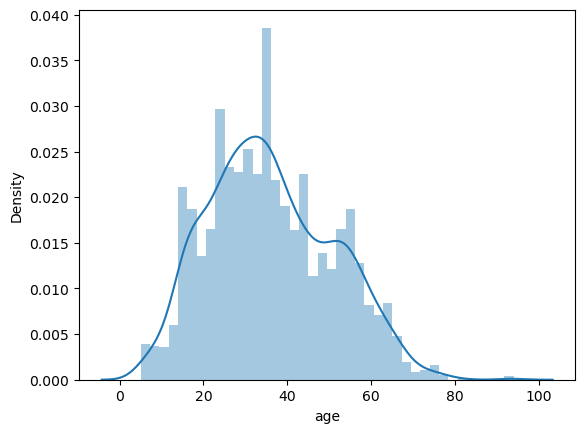

In [307]:
sns.distplot(users[all_merge['category'].str.contains('juvenile',na=False)]['age'],bins=40)
plt.show()

/tmp/ipykernel_44097/845381370.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(users['age'],bins=40)


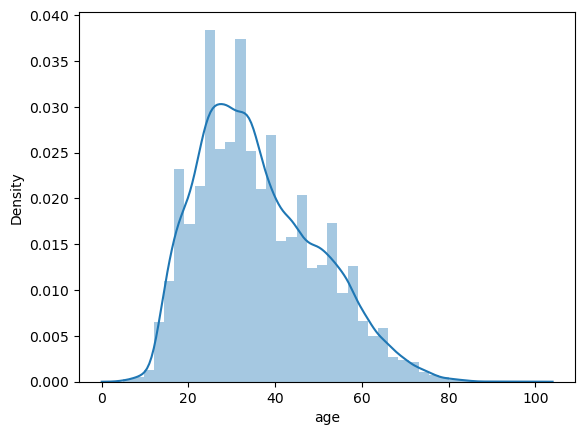

In [185]:
sns.distplot(users['age'],bins=40)
plt.show()

In [308]:
def age_map(x: int) -> int:
    x = int(x)
    if x < 20:
        return 1
    elif x >= 20 and x < 30:
        return 2
    elif x >= 30 and x < 40:
        return 3
    elif x >= 40 and x < 50:
        return 4
    elif x >= 50 and x < 60:
        return 5
    else:
        return 6
    
drop_age_nan = users.dropna(subset=['age'], how='any', axis=0)
drop_age_nan = drop_age_nan['age'].apply(age_map)


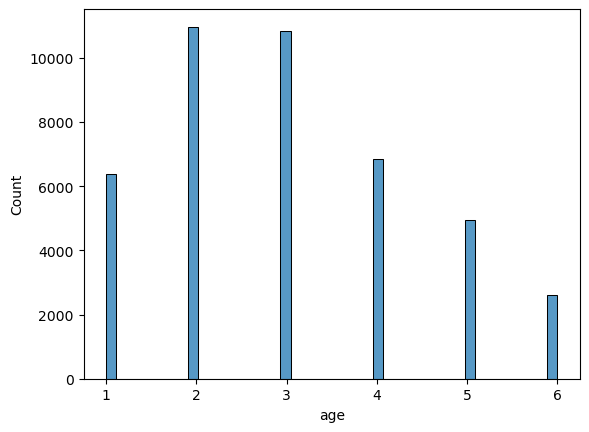

In [309]:
sns.histplot(drop_age_nan)
plt.show()

age가 nan인 유저 별 가장 많이 구매한 category를 추출

해당 category의 평균 나이로 메꾸기

In [331]:
all_merge[all_merge['age'].isna()].head()

,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
0,8,"timmins, ontario, canada",NaN,0002005018,4,Clara Callan,richard bruce wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
2,123629,"kingston, ontario, canada",NaN,0002005018,8,Clara Callan,richard bruce wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
3,200273,"comber, ontario, canada",NaN,0002005018,8,Clara Callan,richard bruce wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
4,210926,"guelph, ontario, canada",NaN,0002005018,9,Clara Callan,richard bruce wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
7,8,"timmins, ontario, canada",NaN,074322678X,4,Where You'll Find Me: And Other Stories,ann beattie,2002.0,Scribner,http://images.amazon.com/images/P/074322678X.0...,en,['fiction'],"Now back in print, Ann Beattie&#39;s finest sh...",images/074322678X.01.THUMBZZZ.jpg


In [349]:
users_with_missing_age = all_merge[all_merge['age'].isnull()]

for user_id in users_with_missing_age['user_id'].unique():
    try:
        users_top_category = all_merge[all_merge['user_id']==user_id]['category'].value_counts().idxmax() #유저가 가장 많이 구매한 책의 category
        users.loc[users['user_id'] == user_id, 'age'] = np.around(all_merge[all_merge['category']==users_top_category]['age'].mean()) #해당 category 구매 유저의 평균 나이
        
    except ValueError: # 유저가 구매한 책들 모두 category가 nan인 경우.
            continue

In [350]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   68092 non-null  int64  
 1   location  68092 non-null  object 
 2   age       62707 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ MB


In [352]:
#users.to_csv('/opt/ml/data/users_age.csv',sep=',',index=None)

# 5.location

In [353]:
users

,user_id,location,age
0,8,"timmins, ontario, canada",34.0
1,11400,"ottawa, ontario, canada",49.0
2,11676,"n/a, n/a, n/a",9.0
3,67544,"toronto, ontario, canada",30.0
4,85526,"victoria, british columbia, canada",36.0
...,...,...,...
68087,278376,"danville, pennsylvania, usa",54.0
68088,278621,"victoria, delaware, canada",74.0
68089,278636,"irvington, alabama, usa",NaN
68090,278659,"vancouver, washington, usa",33.0


In [354]:
states_abbreviations = {
    'AK': 'Alaska',
    'AL': 'Alabama',
    'AR': 'Arkansas',
    'AZ': 'Arizona',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DC': 'District of Columbia',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'HI': 'Hawaii',
    'IA': 'Iowa',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'MA': 'Massachusetts',
    'MD': 'Maryland',
    'ME': 'Maine',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MO': 'Missouri',
    'MS': 'Mississippi',
    'MT': 'Montana',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'NE': 'Nebraska',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NV': 'Nevada',
    'NY': 'New York',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VA': 'Virginia',
    'VT': 'Vermont',
    'WA': 'Washington',
    'WI': 'Wisconsin',
    'WV': 'West Virginia',
    'WY': 'Wyoming'
}

states_abbreviations_lowercase = {k.lower(): v.lower() for k,v in states_abbreviations.items()}

def preprocess_location(location):
    country = re.sub("\s+", '', location.split(',')[-1])
    if country == 'usa':
        state = re.sub("\s+", '', location.split(',')[-2])
        
        if state in states_abbreviations_lowercase:
            state = states_abbreviations_lowercase[state]
            
        return country + '-' + state
    else:
        return country

In [355]:
users['location_country'] = users['location'].apply(lambda x: preprocess_location(x)).replace(['theworldtomorrow', 'unknown', 'n/a', ''], np.NaN)

In [356]:
users['location_first'] = users['location'].apply(lambda x: re.sub("\s+", '', x.split(',')[0])).replace(['whoknows', 'unknown', 'n/a', ''], np.NaN)

In [357]:
users.head(20)

,user_id,location,age,location_country,location_first
0,8,"timmins, ontario, canada",34.0,canada,timmins
1,11400,"ottawa, ontario, canada",49.0,canada,ottawa
2,11676,"n/a, n/a, n/a",9.0,NaN,NaN
3,67544,"toronto, ontario, canada",30.0,canada,toronto
4,85526,"victoria, british columbia, canada",36.0,canada,victoria
5,96054,"ottawa, ontario, canada",29.0,canada,ottawa
6,116866,"ottawa, ,",18.0,NaN,ottawa
7,123629,"kingston, ontario, canada",34.0,canada,kingston
8,177458,"ottawa, ontario, canada",29.0,canada,ottawa
9,200273,"comber, ontario, canada",34.0,canada,comber


In [358]:
def substitute_location(row):
    if (type(row['location_country']) == str) | (type(row['location_first']) != str):
        return row
    
    sub_row = users[(users['location_first'] == row['location_first']) & (users['location_country'].notna())][['location_country', 'location_first']]
    if sub_row.shape[0] == 0:
        return row
    else:
        row['location_country'] = sub_row.groupby(sub_row.columns.tolist(),as_index=False).size()['location_country'][0]
        return row

In [359]:
users = users.apply(lambda x: substitute_location(x), axis = 1)

In [360]:
users = users.drop(['location', 'location_first'], axis=1)

In [361]:
location_threshold = 100

country_freq = users['location_country'].value_counts()
low_freq_country = country_freq[country_freq < location_threshold].index.tolist()

def combine_low_countries(country):
    if country in low_freq_country:
        return 'others'
    else:
        return country

users['location_country'] = users['location_country'].apply(lambda x: combine_low_countries(x))

In [363]:
users

,user_id,age,location_country
0,8,34.0,canada
1,11400,49.0,canada
2,11676,9.0,NaN
3,67544,30.0,canada
4,85526,36.0,canada
...,...,...,...
68087,278376,54.0,usa-pennsylvania
68088,278621,74.0,canada
68089,278636,NaN,usa-alabama
68090,278659,33.0,usa-washington


In [364]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           68092 non-null  int64  
 1   age               62707 non-null  float64
 2   location_country  67926 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ MB


In [365]:
users['location_country'] = users['location_country'].fillna(users['location_country'].value_counts().index.tolist()[0])

In [366]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           68092 non-null  int64  
 1   age               62707 non-null  float64
 2   location_country  68092 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ MB


In [367]:
users

,user_id,age,location_country
0,8,34.0,canada
1,11400,49.0,canada
2,11676,9.0,usa-california
3,67544,30.0,canada
4,85526,36.0,canada
...,...,...,...
68087,278376,54.0,usa-pennsylvania
68088,278621,74.0,canada
68089,278636,NaN,usa-alabama
68090,278659,33.0,usa-washington


In [368]:
users.to_csv('/opt/ml/data/users.csv',sep=',',index=None)

#######################################

(# 7.age 무지성 10대로 채우기)

test

In [271]:
users1 = pd.read_csv('/opt/ml/data/users.csv')
users1

,user_id,location,age
0,8,"timmins, ontario, canada",NaN
1,11400,"ottawa, ontario, canada",49.0
2,11676,"n/a, n/a, n/a",NaN
3,67544,"toronto, ontario, canada",30.0
4,85526,"victoria, british columbia, canada",36.0
...,...,...,...
68087,278376,"danville, pennsylvania, usa",54.0
68088,278621,"victoria, delaware, canada",74.0
68089,278636,"irvington, alabama, usa",NaN
68090,278659,"vancouver, washington, usa",33.0


In [276]:
users1.loc[users1['age'].isnull(),'age'] = float(np.random.randint(5, 20, size=1))

In [280]:
users1

,user_id,location,age
0,8,"timmins, ontario, canada",16.0
1,11400,"ottawa, ontario, canada",49.0
2,11676,"n/a, n/a, n/a",16.0
3,67544,"toronto, ontario, canada",30.0
4,85526,"victoria, british columbia, canada",36.0
...,...,...,...
68087,278376,"danville, pennsylvania, usa",54.0
68088,278621,"victoria, delaware, canada",74.0
68089,278636,"irvington, alabama, usa",16.0
68090,278659,"vancouver, washington, usa",33.0
